In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from datetime import datetime

In [91]:
# Read the data
def read_data(path, filename):
    format_datetime_str = "%Y-%m-%dT%H:%M:%S+00:00"
    df = pd.read_csv(join(path, filename),
            sep = ';',
            parse_dates = ['date'],
            date_parser = lambda x: datetime.strptime(x, format_datetime_str)
        )
    return df

# Posts series by month
def get_series(series):
    posts_series = pd.DataFrame(
                            data = [fecha.to_period('M') for fecha in pd.date_range('2016-01-01', '2022-07-31', freq = 'M')], 
                            columns = ['date']
                        )

    posts_series = pd.merge(
                        posts_series, 
                        series, 
                        on = 'date', 
                        how = 'left'
                    )

    posts_series[series.columns[1]].fillna(0, inplace = True)
    return posts_series

# Plot the series
def plot_series(posts_series, column, title, trabajo = False):
    x_hor = np.arange(0, len(posts_series), 1)
    xticks_hor = np.arange(0, len(posts_series), 12)

    plt.style.use("ggplot")
    plt.figure(figsize = (18, 4))
    plt.box(False)
    plt.scatter(
        x_hor, 
        posts_series[column], 
        color = 'tomato', 
        zorder = 2,
        s = 50,
        alpha = .8
    )
    plt.plot(
        x_hor, 
        posts_series[column], 
        color = 'black', 
        zorder = 1,
        linewidth = 2.5
    )

    plt.xticks(
        xticks_hor, 
        posts_series.loc[xticks_hor, :]['date'],
        fontsize = 20
    )

    plt.yticks(fontsize = 20)

    plt.title(title, fontsize = 25)

    plt.show()

# Plot histogram
def plot_histogram(posts_series, column, title):
    plt.style.use("ggplot")
    plt.figure(figsize = (18, 7))
    plt.box(False)
    plt.hist(
        posts_series[column], 
        bins = 40, 
        color = 'tomato', 
        zorder = 2
    )
    plt.xlim(0, 40)
    plt.title(title)
    plt.show()

# Plot bar diagram
def plot_bar(posts_series, column, title):
    plt.style.use("ggplot")
    plt.figure(figsize = (18, 5))
    plt.box(False)
    plt.bar(
        posts_series['day_of_week'], 
        posts_series[column], 
        color = 'tomato', 
        zorder = 2
    )
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()

In [92]:
# Read the data
path = '/Users/carlosandresosorioalcalde/Documents/GitHub/Analizandome/data'
filename = 'notas_en_blanco.csv'
df = read_data(path, filename)

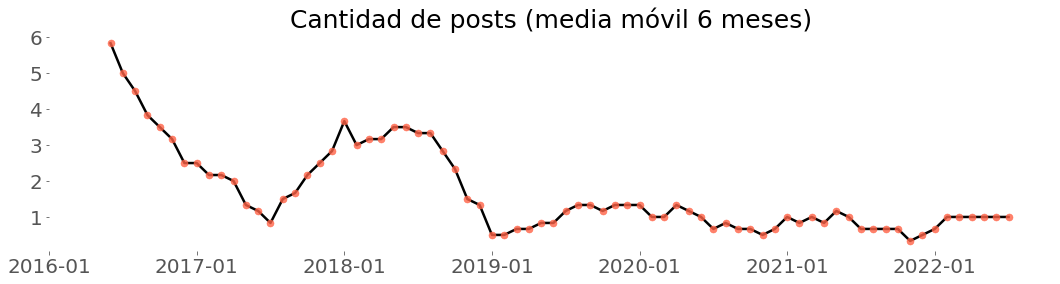

In [93]:
# Get the time series of the posts (moving average of 6 periods)
posts_count = df.groupby(df['date'].dt.to_period('M'))['title'].count().to_frame(name = 'total').reset_index()
post_series = get_series(posts_count)
post_series['rolling'] = post_series['total'].rolling(window = 6).mean()

# Plot series
plot_series(post_series, column = 'rolling', title = 'Cantidad de posts (media móvil 6 meses)')

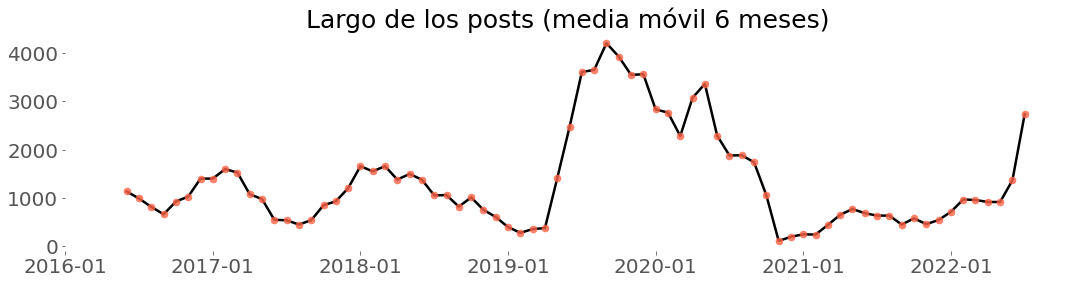

In [94]:
# Analyze the length of the content (just the length of the string). Moving average of 6 periods
df['len_content'] = df['content'].map(lambda x : (len(str(x))))
series_post_mean = df.groupby(df['date'].dt.to_period('M')).len_content.mean().to_frame('len_content').reset_index()
len_series = get_series(series_post_mean)
len_series['rolling'] = len_series['len_content'].rolling(window = 6).mean()

# Plot series
plot_series(len_series, column = 'rolling', title = 'Largo de los posts (media móvil 6 meses)')

In [95]:
# Get the longest post and the shortest post
longest_post = df[df['len_content'] == df['len_content'].max()]['title']
shortest_post = df[df['len_content'] == df['len_content'].min()]['title']

print(f'The longest post was: {longest_post.values[0]} \n The shortest post was: {shortest_post.values}')

The longest post was: El ICFES 
 The shortest post was: ['2018' '2 de mayo']


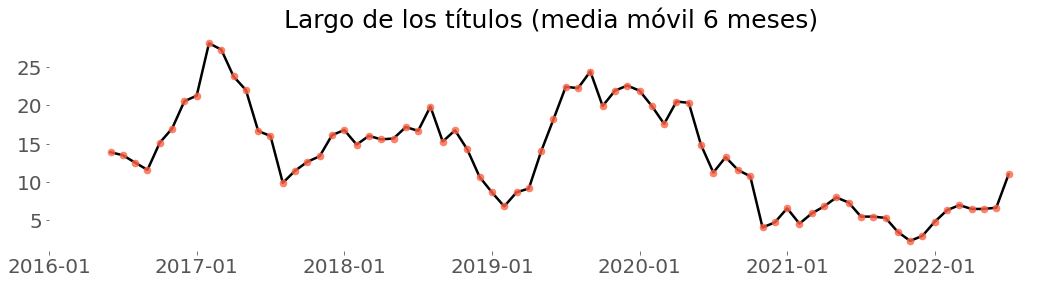

In [96]:
# Create an histogram of the length of the titles
df['len_title'] = df['title'].map(lambda x : (len(str(x))))
series_post_lean_mean = df.groupby(df['date'].dt.to_period('M')).len_title.mean().to_frame('len_title').reset_index()
len_title_series = get_series(series_post_lean_mean)
len_title_series['rolling'] = len_title_series['len_title'].rolling(window = 6).mean()

plot_series(len_title_series, column = 'rolling', title = 'Largo de los títulos (media móvil 6 meses)')

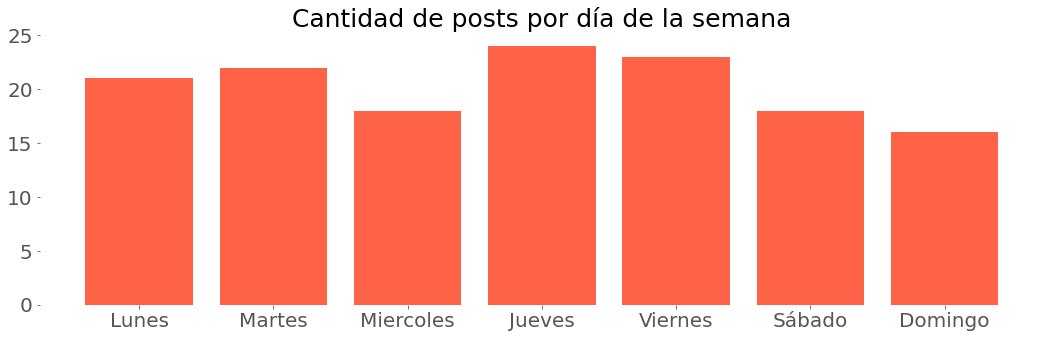

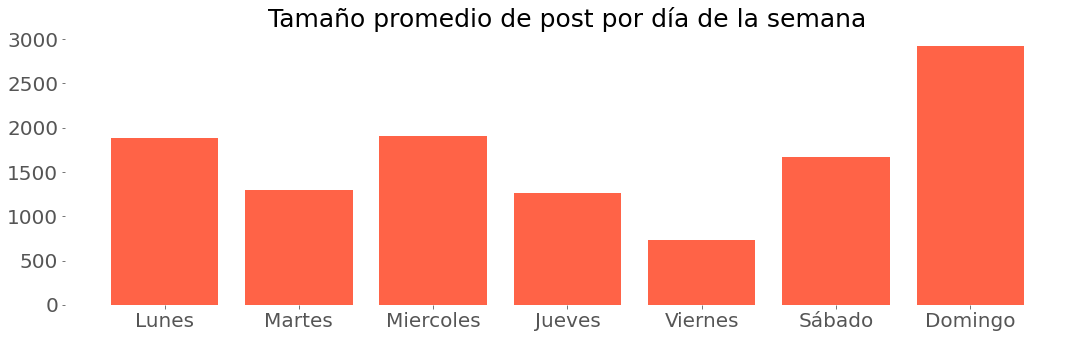

In [97]:
# Extract the day of week
df['day_of_week'] = df['date'].dt.dayofweek
days_week = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df['day_of_week'] = df['day_of_week'].map(lambda x : (pd.Series(days_week)[x]))

# Count the number of posts by day of week
df_posts_day = df.groupby("day_of_week").agg({'title' : 'count', 'len_content' : 'mean'}).reset_index()
custom_dict = dict(
    zip(
        days_week,
        range(len(days_week))
    )
)
df_posts_day.sort_values(by = ['day_of_week'], key = lambda x : x.map(custom_dict), inplace = True)

# Order the df_posts_day dataframe
plot_bar(df_posts_day, column = 'title', title = 'Cantidad de posts por día de la semana')
plot_bar(df_posts_day, column = 'len_content', title = 'Tamaño promedio de post por día de la semana')